In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import time
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 设置随机种子以确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


In [15]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 dropout, embedding_weights=None, train_embedding=True):
        super(SentimentLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # 嵌入层
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=not train_embedding)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                           dropout=dropout, batch_first=True, bidirectional=False)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Sigmoid激活函数
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # 嵌入层
        embedded = self.embedding(x)
        
        # LSTM层
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # 取最后一个时间步的输出
        out = self.dropout(lstm_out[:, -1, :])
        
        # 全连接层
        out = self.fc(out)
        
        # Sigmoid激活
        out = self.sigmoid(out)
        
        return out.squeeze()

In [19]:
class SentimentAnalyzer:
    def __init__(self, device='cpu'):
        self.device = device
        self.vocab_size = 0
        self.model = None
    
    def create_model(self, vocab_size, embedding_dim=100, hidden_dim=128, n_layers=2, 
                    dropout=0.3, use_pretrained=False, glove_path=None, train_embedding=True):
        """创建LSTM模型"""
        self.vocab_size = vocab_size
        
        if use_pretrained and glove_path:
            embedding_weights = self.load_glove_embeddings(glove_path, embedding_dim, vocab_size)
            if embedding_weights is not None:
                self.model = SentimentLSTM(
                    vocab_size, embedding_dim, hidden_dim, 1, n_layers, 
                    dropout, embedding_weights, train_embedding
                )
                print("使用预训练GloVe词向量的模型已创建")
            else:
                print("无法加载预训练词向量，使用随机初始化")
                use_pretrained = False
        
        if not use_pretrained:
            self.model = SentimentLSTM(
                vocab_size, embedding_dim, hidden_dim, 1, n_layers, 
                dropout, None, True
            )
            print("使用随机初始化词向量的模型已创建")
        
        self.model = self.model.to(self.device)
        return self.model
    
    def load_glove_embeddings(self, glove_path, embedding_dim, vocab_size):
        """加载预训练的GloVe词向量"""
        print("加载GloVe词向量...")
        
        # 由于我们不知道确切的词汇表，我们假设索引0-29999对应词汇表中的词
        embedding_weights = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))
        
        try:
            glove_embeddings = {}
            with open(glove_path, 'r', encoding='utf-8') as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    vector = np.asarray(values[1:], dtype='float32')
                    glove_embeddings[word] = vector
            
            print("注意: 由于缺乏索引到词的映射，无法精确加载GloVe词向量")
            print("使用随机初始化替代")
            
        except FileNotFoundError:
            print(f"GloVe文件未找到: {glove_path}")
            print("请从 https://nlp.stanford.edu/projects/glove/ 下载GloVe词向量")
            return None
        
        return torch.tensor(embedding_weights, dtype=torch.float32)
    
    def train_model(self, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
        """训练模型"""
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        best_val_loss = float('inf')
        patience = 3
        patience_counter = 0
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            # 训练阶段
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (sequences, masks, labels, lengths) in enumerate(train_loader):
                sequences = sequences.to(self.device)
                labels = labels.to(self.device).float()
                
                optimizer.zero_grad()
                outputs = self.model(sequences)  # 不再传递lengths参数
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                predicted = (outputs > 0.5).float()
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                # 每100个batch打印一次进度
                if batch_idx % 100 == 0:
                    print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
            
            # 验证阶段
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for sequences, masks, labels, lengths in val_loader:
                    sequences = sequences.to(self.device)
                    labels = labels.to(self.device).float()
                    
                    outputs = self.model(sequences)  # 不再传递lengths参数
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    predicted = (outputs > 0.5).float()
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            # 计算平均损失和准确率
            train_loss_avg = train_loss / len(train_loader)
            val_loss_avg = val_loss / len(val_loader)
            train_accuracy = train_correct / train_total
            val_accuracy = val_correct / val_total
            
            train_losses.append(train_loss_avg)
            val_losses.append(val_loss_avg)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            epoch_time = time.time() - start_time
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Time: {epoch_time:.2f}s')
            print(f'  训练损失: {train_loss_avg:.4f}, 训练准确率: {train_accuracy:.4f}')
            print(f'  验证损失: {val_loss_avg:.4f}, 验证准确率: {val_accuracy:.4f}')
            
            # 早停法
            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                patience_counter = 0
                # 保存最佳模型
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"早停：验证损失在 {patience} 个epoch内没有改善")
                    break
        
        # 加载最佳模型
        # 在代码中找到这行并修改
        self.model.load_state_dict(torch.load('best_model.pth', weights_only=True))
        
        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }
    
    def evaluate_model(self, test_loader):
        """评估模型"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for sequences, masks, labels, lengths in test_loader:
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(sequences)  # 不再传递lengths参数
                predictions = (outputs > 0.5).float()
                
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())
        
        # 计算评估指标
        accuracy = accuracy_score(all_targets, all_predictions)
        precision = precision_score(all_targets, all_predictions, zero_division=0)
        recall = recall_score(all_targets, all_predictions, zero_division=0)
        f1 = f1_score(all_targets, all_predictions, zero_division=0)
        
        print("\n" + "="*50)
        print("模型评估结果")
        print("="*50)
        print(f"准确率 (Accuracy): {accuracy:.4f}")
        print(f"精确率 (Precision): {precision:.4f}")
        print(f"召回率 (Recall): {recall:.4f}")
        print(f"F1分数: {f1:.4f}")
        print("\n分类报告:")
        print(classification_report(all_targets, all_predictions, target_names=['负面', '正面']))
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': all_predictions,
            'targets': all_targets
        }

In [20]:
def plot_training_history(history, model_name):
    """绘制训练历史"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 绘制损失曲线
    ax1.plot(history['train_losses'], label='训练损失')
    ax1.plot(history['val_losses'], label='验证损失')
    ax1.set_title(f'{model_name} - 损失曲线')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # 绘制准确率曲线
    ax2.plot(history['train_accuracies'], label='训练准确率')
    ax2.plot(history['val_accuracies'], label='验证准确率')
    ax2.set_title(f'{model_name} - 准确率曲线')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


In [21]:
def simple_train_and_evaluate(analyzer, train_loader, val_loader, test_loader, vocab_size, use_pretrained=False):
    """简化的训练和评估流程"""
    print("\n" + "="*80)
    print(f"训练{'预训练嵌入' if use_pretrained else '随机嵌入'}模型")
    print("="*80)
    
    # 创建模型
    analyzer.create_model(
        vocab_size=vocab_size,
        hidden_dim=128,
        dropout=0.3,
        use_pretrained=use_pretrained
    )
    
    # 训练模型
    history = analyzer.train_model(
        train_loader, val_loader,
        learning_rate=0.001,
        num_epochs=5  # 减少epoch数以加快实验
    )
    
    # 评估模型
    results = analyzer.evaluate_model(test_loader)
    plot_training_history(history, f"{'预训练嵌入' if use_pretrained else '随机嵌入'}模型")
    
    return results


开始情感分析项目...
加载数据...
数据加载成功!
训练集: 32000 个样本
验证集: 8000 个样本
测试集: 10000 个样本
词汇表大小: 30000

=== 数据诊断信息 ===
训练集大小: 32000
验证集大小: 8000
测试集大小: 10000
训练集标签分布: Counter({0: 16000, 1: 16000})
验证集标签分布: Counter({1: 4000, 0: 4000})
测试集标签分布: Counter({0: 5000, 1: 5000})
序列形状: torch.Size([32000, 512])
序列数据类型: torch.int64
序列值范围: [0, 29999]
样本标签示例: [0 1 0 0 1 0 1 1 0 0]
训练设备: cuda


开始训练随机嵌入模型...

训练随机嵌入模型
使用随机初始化词向量的模型已创建


C:\Users\16381\AppData\Local\Temp\ipykernel_19832\2579862064.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(r"C:\Users\16381\Desktop\all_data.pt")


Epoch 1/5, Batch 0/1000, Loss: 0.6914
Epoch 1/5, Batch 100/1000, Loss: 0.6984
Epoch 1/5, Batch 200/1000, Loss: 0.6902
Epoch 1/5, Batch 300/1000, Loss: 0.6950
Epoch 1/5, Batch 400/1000, Loss: 0.6895
Epoch 1/5, Batch 500/1000, Loss: 0.6908
Epoch 1/5, Batch 600/1000, Loss: 0.6823
Epoch 1/5, Batch 700/1000, Loss: 0.7059
Epoch 1/5, Batch 800/1000, Loss: 0.6925
Epoch 1/5, Batch 900/1000, Loss: 0.7004
Epoch [1/5], Time: 19.21s
  训练损失: 0.6936, 训练准确率: 0.5009
  验证损失: 0.6923, 验证准确率: 0.5008
Epoch 2/5, Batch 0/1000, Loss: 0.6880
Epoch 2/5, Batch 100/1000, Loss: 0.7080
Epoch 2/5, Batch 200/1000, Loss: 0.6952
Epoch 2/5, Batch 300/1000, Loss: 0.6951
Epoch 2/5, Batch 400/1000, Loss: 0.6926
Epoch 2/5, Batch 500/1000, Loss: 0.6931
Epoch 2/5, Batch 600/1000, Loss: 0.7062
Epoch 2/5, Batch 700/1000, Loss: 0.6975
Epoch 2/5, Batch 800/1000, Loss: 0.6761
Epoch 2/5, Batch 900/1000, Loss: 0.6981
Epoch [2/5], Time: 19.18s
  训练损失: 0.6928, 训练准确率: 0.5094
  验证损失: 0.6920, 验证准确率: 0.5101
Epoch 3/5, Batch 0/1000, Loss: 0

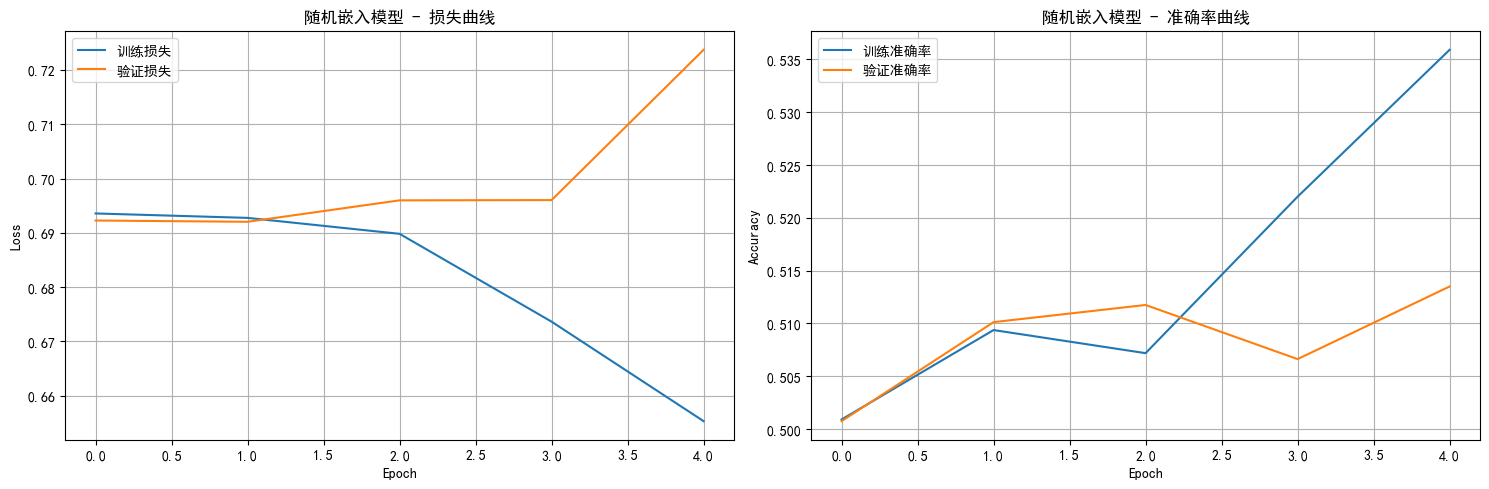


开始训练预训练嵌入模型...

训练预训练嵌入模型
Epoch 1/5, Batch 0/1000, Loss: 0.6827
Epoch 1/5, Batch 100/1000, Loss: 0.7002
Epoch 1/5, Batch 200/1000, Loss: 0.6978
Epoch 1/5, Batch 300/1000, Loss: 0.6713
Epoch 1/5, Batch 400/1000, Loss: 0.6759
Epoch 1/5, Batch 500/1000, Loss: 0.6569
Epoch 1/5, Batch 600/1000, Loss: 0.6958
Epoch 1/5, Batch 700/1000, Loss: 0.6922
Epoch 1/5, Batch 800/1000, Loss: 0.7001
Epoch 1/5, Batch 900/1000, Loss: 0.6827
Epoch [1/5], Time: 19.17s
  训练损失: 0.6872, 训练准确率: 0.5135
  验证损失: 0.6944, 验证准确率: 0.5122
Epoch 2/5, Batch 0/1000, Loss: 0.6855
Epoch 2/5, Batch 100/1000, Loss: 0.6983
Epoch 2/5, Batch 200/1000, Loss: 0.6817
Epoch 2/5, Batch 300/1000, Loss: 0.6539
Epoch 2/5, Batch 400/1000, Loss: 0.6336
Epoch 2/5, Batch 500/1000, Loss: 0.6435
Epoch 2/5, Batch 600/1000, Loss: 0.6993
Epoch 2/5, Batch 700/1000, Loss: 0.6566
Epoch 2/5, Batch 800/1000, Loss: 0.7091
Epoch 2/5, Batch 900/1000, Loss: 0.6867
Epoch [2/5], Time: 19.33s
  训练损失: 0.6772, 训练准确率: 0.5301
  验证损失: 0.6983, 验证准确率: 0.5095
Epoch

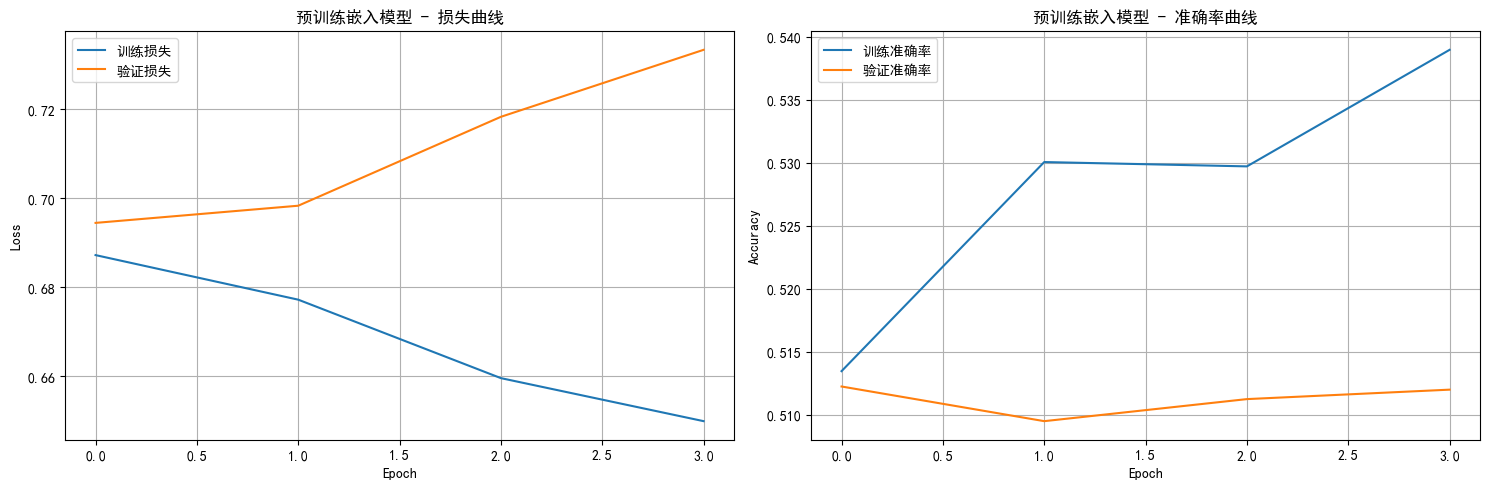


模型比较结果
随机嵌入模型 - 准确率: 0.5082, F1: 0.1161
预训练嵌入模型 - 准确率: 0.5074, F1: 0.1079
随机嵌入模型表现更好!

项目完成!


In [23]:
def main():
    """主函数"""
    print("开始情感分析项目...")
    
    # 加载数据
    print("加载数据...")
    try:
        data = torch.load(r"C:\Users\16381\Desktop\all_data.pt")
        print("数据加载成功!")
        
        # 提取训练、验证和测试数据
        train_sequences = data['train_sequences']
        train_masks = data['train_masks']
        train_labels = data['train_labels']
        train_lengths = data['train_lengths']
        
        val_sequences = data['val_sequences']
        val_masks = data['val_masks']
        val_labels = data['val_labels']
        val_lengths = data['val_lengths']
        
        test_sequences = data['test_sequences']
        test_masks = data['test_masks']
        test_labels = data['test_labels']
        test_lengths = data['test_lengths']
        
        print(f"训练集: {len(train_sequences)} 个样本")
        print(f"验证集: {len(val_sequences)} 个样本")
        print(f"测试集: {len(test_sequences)} 个样本")
        
        # 计算词汇表大小（从序列中的最大索引+1）
        vocab_size = max(
            train_sequences.max().item(),
            val_sequences.max().item(),
            test_sequences.max().item()
        ) + 1
        print(f"词汇表大小: {vocab_size}")
        
        # 创建数据集
        train_dataset = TensorDataset(train_sequences, train_masks, train_labels, train_lengths)
        val_dataset = TensorDataset(val_sequences, val_masks, val_labels, val_lengths)
        test_dataset = TensorDataset(test_sequences, test_masks, test_labels, test_lengths)
        
        # 创建数据加载器
        batch_size = 32
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # ===== 在这里添加诊断代码 =====
        print("\n=== 数据诊断信息 ===")
        print(f"训练集大小: {len(train_dataset)}")
        print(f"验证集大小: {len(val_dataset)}")
        print(f"测试集大小: {len(test_dataset)}")
        
        # 检查标签分布
        print(f"训练集标签分布: {Counter(train_labels.numpy())}")
        print(f"验证集标签分布: {Counter(val_labels.numpy())}")
        print(f"测试集标签分布: {Counter(test_labels.numpy())}")
        
        # 检查序列数据
        print(f"序列形状: {train_sequences.shape}")
        print(f"序列数据类型: {train_sequences.dtype}")
        print(f"序列值范围: [{train_sequences.min()}, {train_sequences.max()}]")
        print(f"样本标签示例: {train_labels[:10].numpy()}")
        
        # 检查设备
        print(f"训练设备: {device}")
        print("====================\n")
        
    except Exception as e:
        print(f"数据加载失败: {e}")
        return
    
    # 其余的代码保持不变...
    
    # 初始化分析器
    analyzer = SentimentAnalyzer(device=device)
    
    # 简化的训练流程 - 只训练随机嵌入模型
    print("\n开始训练随机嵌入模型...")
    random_results = simple_train_and_evaluate(analyzer, train_loader, val_loader, test_loader, vocab_size, use_pretrained=False)
    
    # 尝试预训练嵌入模型（如果GloVe文件可用）
    glove_path = "glove.6B.100d.txt"  # 请根据实际情况修改路径
    try:
        print("\n开始训练预训练嵌入模型...")
        pretrained_results = simple_train_and_evaluate(analyzer, train_loader, val_loader, test_loader, vocab_size, use_pretrained=True)
        
        # 比较结果
        print("\n" + "="*80)
        print("模型比较结果")
        print("="*80)
        print(f"随机嵌入模型 - 准确率: {random_results['accuracy']:.4f}, F1: {random_results['f1']:.4f}")
        print(f"预训练嵌入模型 - 准确率: {pretrained_results['accuracy']:.4f}, F1: {pretrained_results['f1']:.4f}")
        
        if pretrained_results['accuracy'] > random_results['accuracy']:
            print("预训练嵌入模型表现更好!")
        else:
            print("随机嵌入模型表现更好!")
            
    except Exception as e:
        print(f"预训练嵌入模型训练失败: {e}")
        print("请确保GloVe词向量文件可用，或使用随机嵌入模型")
    
    print("\n项目完成!")

if __name__ == "__main__":
    main()